In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

import SessionTools.two_photon as st2p

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [23]:
a = [0, 1, 2]
print(np.roll(a,1))

[2 0 1]


In [2]:


def corr_w_lags(pp, shifts = [i for i in range(-11,12,1)], chan = -1):
    '''
    '''
    
    dff = pp.calculate_zscored_F('rois', zscore=True, exp_detrend = True)[chan, :, :] 
    
   
    # note smoothing conditions
    dff = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(dff, 1, axis=-1),.5,axis=0, mode='wrap')
    
    
    # get PV and heading
    heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
    x_h, y_h = st2p.utilities.pol2cart(np.ones(heading.shape),heading)
    # _, heading_sm = st2p.utilities.cart2pol(sp.ndimage.gaussian_filter1d(x_h,3), sp.ndimage.gaussian_filter1d(y_h,3))

    x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
    rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0)) # vector average
#     rho,phi = st2p.utilities.cart2pol(sp.ndimage.gaussian_filter1d(x_f.mean(axis=0),3), 
#                                       sp.ndimage.gaussian_filter1d(y_f.mean(axis=0),3))
    
    _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
    
    # calculate dPVA/dt and dHeading/dt
    dh = np.diff(np.unwrap(heading))
    dphi = np.diff(np.unwrap(phi))
    

    # get time bins for 10 frame shift in either direction
    volume_dt = np.diff(np.array(pp.metadata['frame_times'])[:,0])[0]
    shift_bins = np.arange(-10*volume_dt,10*volume_dt+1E-5,volume_dt)
    
    # calculate correlation at different lags
    times = volume_dt*np.array(shifts)
    xcorr = np.zeros((len(shifts),))
    
    for i, shift in enumerate(shifts):
        dphi_shift = np.roll(dphi,int(shift))
        xcorr[i] = np.corrcoef(dphi_shift, dh)[0,1]
        
    return xcorr, times 




    
# save vector for each fly, broken out by genotype & dark vs closed loop

In [3]:
common_times = np.arange(-10,11,1)*.1
print(common_times)

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


# TBH RNAi

### R18B05 Gal4

In [4]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R60D05LexA_jGCaMP7b_R18B05Gal4_TBHRNAi')
sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['gal4_line'] + '_' + row['rnai_line '] for _, row in sess_df.iterrows()]
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/R60D05LexA_jGCaMP7b_R18B05Gal4_TBHRNAi/')

figfolder.mkdir(parents=True, exist_ok=True)
eg_folder = figfolder / 'sessions'
eg_folder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]
sess_df = sess_df.loc[~((sess_df['closed_loop']==0) * (sess_df['dark']==0))]



Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'closed_loop', 'dark',
       'rnai_line ', 'gal4_line', 'usable', 'fictrac_dat_file', 'notes'],
      dtype='object')


In [5]:
def el_rnai_epg_image_xcorr_loop(df):
    
    xcorr_arr = []
    # for each session
    for _,row in df.iterrows():
        if row['gal4_line']!='control':
            outdir = pathlib.PurePath( basedir / row['rnai_line '] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
            rnai = row['rnai_line ']
        else:
            outdir = pathlib.PurePath( basedir / 'gal4_control' / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
            rnai = 'gal4_control'


        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        # calculate cross correlation
        xcorr, times = corr_w_lags(pp)
        # resample to across fly timing using linear splines
        spline = interp1d(times, xcorr, kind='linear')

        xcorr_arr.append(spline(common_times))

    return np.array(xcorr_arr)



cl_ctrl_mask = ((sess_df['rnai_line ']=='control') | (sess_df['gal4_line']=='control')) * (sess_df['closed_loop']>1)
xcorr_cl_ctrl = el_rnai_epg_image_xcorr_loop(sess_df.loc[cl_ctrl_mask])

dark_ctrl_mask = ((sess_df['rnai_line ']=='control') | (sess_df['gal4_line']=='control')) * (sess_df['closed_loop']==0)
xcorr_dark_ctrl = el_rnai_epg_image_xcorr_loop(sess_df.loc[dark_ctrl_mask])

cl_rnai_mask = (sess_df['rnai_line ']=='rnai_67968') * (sess_df['closed_loop']>1)
xcorr_cl_rnai = el_rnai_epg_image_xcorr_loop(sess_df.loc[cl_rnai_mask])

cl_rnai_mask = (sess_df['rnai_line ']=='rnai_67968') * (sess_df['closed_loop']==0)
xcorr_dark_rnai = el_rnai_epg_image_xcorr_loop(sess_df.loc[cl_rnai_mask])


Text(0.5, 1.0, 'TBH RNAi')

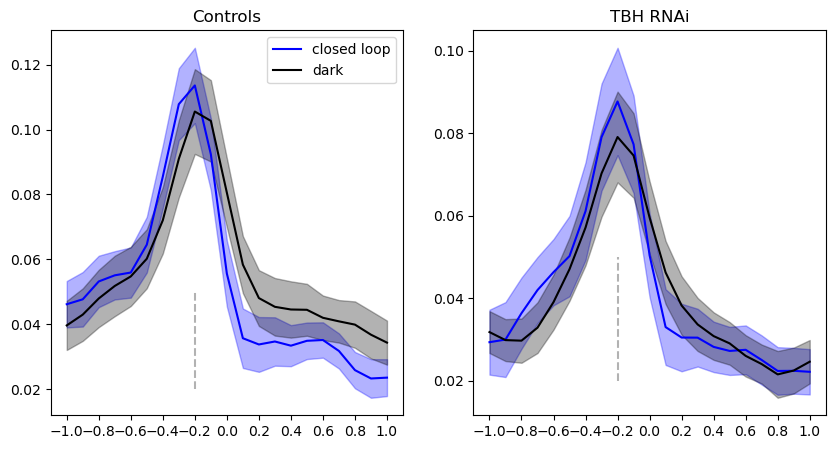

In [6]:
# xcorr_cl_ctrl.shape
fig, ax = plt.subplots(1,2, figsize=[10,5])

mu, sem = xcorr_cl_ctrl.mean(axis=0), sp.stats.sem(xcorr_cl_ctrl, axis=0)
_ = ax[0].plot(common_times, mu, color='blue', label='closed loop')
_ = ax[0].fill_between(common_times, mu-sem, mu+sem, color='blue', alpha = .3)

mu, sem = xcorr_dark_ctrl.mean(axis=0), sp.stats.sem(xcorr_dark_ctrl, axis=0)
_ = ax[0].plot(common_times, mu, color='black', label='dark')
_ = ax[0].fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)

_ = ax[0].set_xticks(common_times[::2])
_ = ax[0].plot([-.2,-.2], [.02, .05], 'k--', alpha=.3)
ax[0].legend()

mu, sem = xcorr_cl_rnai.mean(axis=0), sp.stats.sem(xcorr_cl_rnai, axis=0)
_ = ax[1].plot(common_times, mu, color='blue')
_ = ax[1].fill_between(common_times, mu-sem, mu+sem, color='blue', alpha = .3)

mu, sem = xcorr_dark_rnai.mean(axis=0), sp.stats.sem(xcorr_dark_rnai, axis=0)
_ = ax[1].plot(common_times, mu, color='black')
_ = ax[1].fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)

_ = ax[1].set_xticks(common_times[::2])
_ = ax[1].plot([-.2,-.2], [.02, .05], 'k--', alpha=.3)


ax[0].set_title('Controls')
ax[1].set_title('TBH RNAi')

### EL split

In [7]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EL_jGCaMP7b_TBHRNAi')

sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['gal4_line'] + '_' + row['rnai_line '] for _, row in sess_df.iterrows()]

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_meetings/EL_jGCaMP7b_TBHRNAi/')
figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]
sess_df = sess_df.loc[~((sess_df['closed_loop']==0) & (sess_df['dark']==0))]



Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'closed_loop', 'dark',
       'rnai_line ', 'gal4_line', 'usable', 'fictrac_dat_file', 'notes'],
      dtype='object')


In [8]:
def el_rnai_image_xcorr_loop(df):
    
    xcorr_arr = []
    # for each session
    for _,row in df.iterrows():
        outdir = pathlib.PurePath( basedir / row['rnai_line '] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        rnai = row['rnai_line ']
        
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        # calculate cross correlation
        xcorr, times = corr_w_lags(pp)
        # resample to across fly timing using linear splines
        spline = interp1d(times, xcorr, kind='linear')

        xcorr_arr.append(spline(common_times))

    return np.array(xcorr_arr)


        

In [9]:
sess_df['rnai_line '].unique()

array(['control', 'rnai_67968', 'vglut_rnai', 'vacht_rnai'], dtype=object)

In [10]:
cl_ctrl_mask = (sess_df['rnai_line ']=='control') * (sess_df['closed_loop']>1)
xcorr_cl_ctrl = el_rnai_image_xcorr_loop(sess_df.loc[cl_ctrl_mask])

dark_ctrl_mask = (sess_df['rnai_line ']=='control') * (sess_df['dark']>=1)
xcorr_dark_ctrl = el_rnai_image_xcorr_loop(sess_df.loc[dark_ctrl_mask])

cl_vglut_mask = (sess_df['rnai_line ']=='vglut_rnai') * (sess_df['closed_loop']>1)
xcorr_cl_vglut = el_rnai_image_xcorr_loop(sess_df.loc[cl_vglut_mask])

dark_vglut_mask = (sess_df['rnai_line ']=='vglut_rnai') * (sess_df['dark']>=1)
xcorr_dark_vglut = el_rnai_image_xcorr_loop(sess_df.loc[dark_vglut_mask])


cl_rnai_mask = (sess_df['rnai_line ']=='rnai_67968') * (sess_df['closed_loop']>1)
xcorr_cl_rnai = el_rnai_image_xcorr_loop(sess_df.loc[cl_rnai_mask])

dark_rnai_mask = (sess_df['rnai_line ']=='rnai_67968') * (sess_df['dark']>=1)
xcorr_dark_rnai = el_rnai_image_xcorr_loop(sess_df.loc[dark_rnai_mask])



Text(0.5, 1.0, 'TBH RNAi')

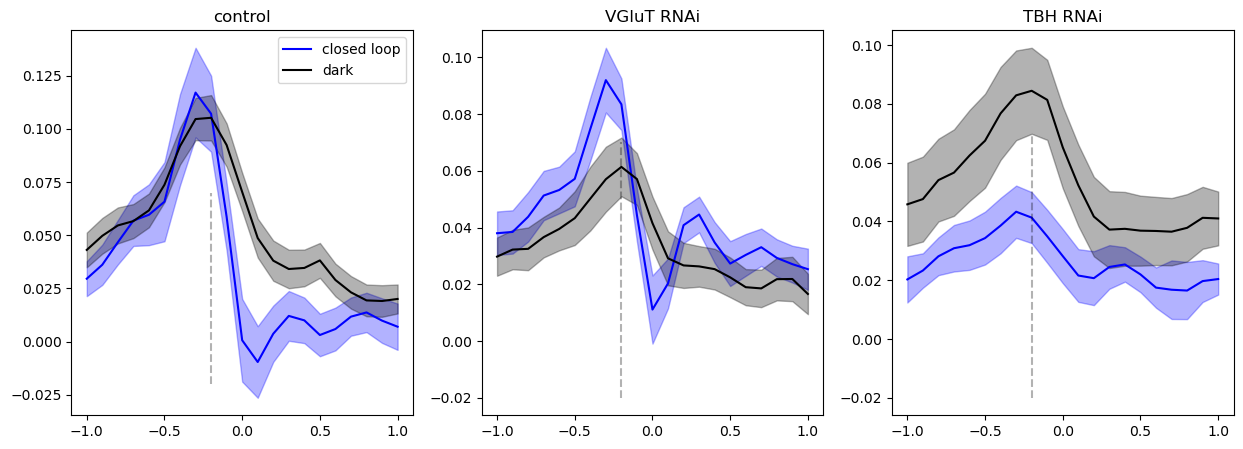

In [11]:
fig, ax = plt.subplots(1,3, figsize=[15,5])

##
mu, sem = xcorr_cl_ctrl.mean(axis=0), sp.stats.sem(xcorr_cl_ctrl, axis=0)
_ = ax[0].plot(common_times, mu, color='blue', label='closed loop')
_ = ax[0].fill_between(common_times, mu-sem, mu+sem, color='blue', alpha = .3)
_ = ax[0].plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)

mu, sem = xcorr_dark_ctrl.mean(axis=0), sp.stats.sem(xcorr_dark_ctrl, axis=0)
_ = ax[0].plot(common_times, mu, color='black', label='dark')
_ = ax[0].fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)
ax[0].set_title('control')
ax[0].legend()

##
mu, sem = xcorr_cl_vglut.mean(axis=0), sp.stats.sem(xcorr_cl_vglut, axis=0)
_ = ax[1].plot(common_times, mu, color='blue')
_ = ax[1].fill_between(common_times, mu-sem, mu+sem, color='blue', alpha = .3)
_ = ax[1].plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)

mu, sem = xcorr_dark_vglut.mean(axis=0), sp.stats.sem(xcorr_dark_vglut, axis=0)
_ = ax[1].plot(common_times, mu, color='black')
_ = ax[1].fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)
ax[1].set_title('VGluT RNAi')

##
mu, sem = xcorr_cl_rnai.mean(axis=0), sp.stats.sem(xcorr_cl_rnai, axis=0)
_ = ax[2].plot(common_times, mu, color='blue')
_ = ax[2].fill_between(common_times, mu-sem, mu+sem, color='blue', alpha = .3)
_ = ax[2].plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)

mu, sem = xcorr_dark_rnai.mean(axis=0), sp.stats.sem(xcorr_dark_rnai, axis=0)
_ = ax[2].plot(common_times, mu, color='black')
_ = ax[2].fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)
ax[2].set_title('TBH RNAi')

## EL hckcr1

In [12]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R60D05LexA_jGCaMP7b_CsChrimsontdT_EL_hcKCR1')

sess_df = pd.read_csv(basedir / 'sessions.csv')
# print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['condition'] for _, row in sess_df.iterrows()]

sess_df = sess_df.loc[sess_df['usable']==1]
scan_type_mask = [scan in set(('baseline', 'post_0deg','post_180deg')) for scan in sess_df['scan_type']]
# print(scan_type_mask)
sess_df = sess_df.loc[scan_type_mask]


In [13]:
sess_df.head()

,date,fly,sess,condition,scan_type,usable,notes,fly_id
0,19_11_2024,fly1,baseline-000,hckcr1,baseline,1,NaN,19_11_2024_fly1_hckcr1
2,19_11_2024,fly1,post_0deg-002,hckcr1,post_0deg,1,NaN,19_11_2024_fly1_hckcr1
4,19_11_2024,fly1,post_180deg-004,hckcr1,post_180deg,1,NaN,19_11_2024_fly1_hckcr1
5,19_11_2024,fly2,baseline-000,hckcr1,baseline,1,NaN,19_11_2024_fly2_hckcr1
7,19_11_2024,fly2,post_180deg-003,hckcr1,post_180deg,1,NaN,19_11_2024_fly2_hckcr1


In [14]:
def epg_remap_el_hckcr1_xcorr_loop(df):
    
    xcorr_arr = []
    # for each session
    for _,row in df.iterrows():
        outdir = pathlib.PurePath( basedir / row['condition'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        # calculate cross correlation
        xcorr, times = corr_w_lags(pp)
        # resample to across fly timing using linear splines
        spline = interp1d(times, xcorr, kind='linear')

        xcorr_arr.append(spline(common_times))

    return np.array(xcorr_arr)



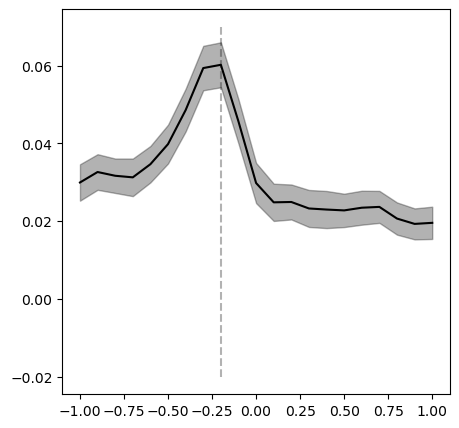

In [15]:
xcorr = epg_remap_el_hckcr1_xcorr_loop(sess_df)

fig, ax = plt.subplots( figsize=[5,5])

##
mu, sem = xcorr.mean(axis=0), sp.stats.sem(xcorr, axis=0)
_ = ax.plot(common_times, mu, color='black')
_ = ax.fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)
_ = ax.plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)



# Remapping data

In [16]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f/remapping')

sess_df = pd.read_csv(basedir / 'sessions.csv')
# print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['condition'] for _, row in sess_df.iterrows()]

sess_df = sess_df.loc[sess_df['usable']==1]
scan_type_mask = (sess_df['scan_type']=='baseline') | (sess_df['scan_type']=='post_0deg') | (sess_df['scan_type']=='post_180deg') \
                 | (sess_df['scan_type']=='post_novis1') | (sess_df['scan_type']=='post_novis2')
condition_mask = (sess_df['condition']=='remap') | (sess_df['condition']=='novis_control') | (sess_df['condition']=='no_chrimson')

sess_df = sess_df.loc[scan_type_mask & condition_mask ]


In [17]:
def el_remap_epg_image_xcorr_loop(df):
    
    xcorr_arr = []
    # for each session
    for _,row in df.iterrows():
        outdir = pathlib.PurePath( basedir / row['condition'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        # calculate cross correlation
        xcorr, times = corr_w_lags(pp)
        # resample to across fly timing using linear splines
        spline = interp1d(times, xcorr, kind='linear')

        xcorr_arr.append(spline(common_times))

    return np.array(xcorr_arr)

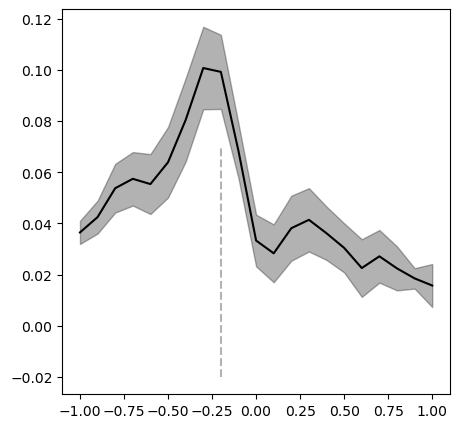

In [18]:
xcorr = el_remap_epg_image_xcorr_loop(sess_df)

fig, ax = plt.subplots( figsize=[5,5])

##
mu, sem = xcorr.mean(axis=0), sp.stats.sem(xcorr, axis=0)
_ = ax.plot(common_times, mu, color='black')
_ = ax.fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)
_ = ax.plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)



# EPG across dark sesssions



In [27]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7f_OctB1RRNAi')
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EPG_jGCaMP7f_OctB1RRNAi/')

sess_df = pd.read_csv(basedir / 'sessions.csv')
# print(sess_df.columns)
rnaistr = []
for _, row in sess_df.iterrows():
    if row['rnai']>0:
        rnaistr.append('rnai')
    else:
        rnaistr.append('control')
sess_df['rnai_line']=rnaistr

sess_df = sess_df.loc[(sess_df['usable']==1) & (sess_df['rnai']==0)]




In [28]:
def epg_image_xcorr_loop(df):
    
    xcorr_arr = []
    # for each session
    for _,row in df.iterrows():
        outdir = pathlib.PurePath( basedir / row['rnai_line'] / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')
        
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        # calculate cross correlation
        xcorr, times = corr_w_lags(pp)
        # resample to across fly timing using linear splines
        spline = interp1d(times, xcorr, kind='linear')

        xcorr_arr.append(spline(common_times))

    return np.array(xcorr_arr)

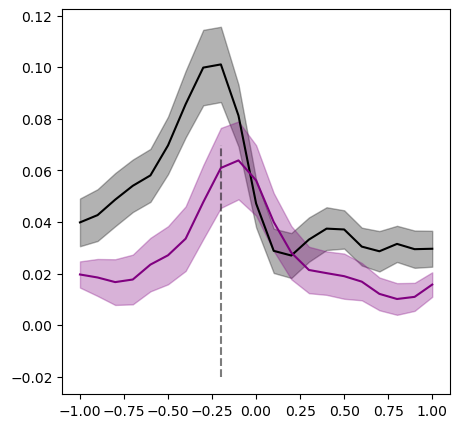

In [29]:
xcorr_cl = epg_image_xcorr_loop(sess_df.loc[(sess_df['closed_loop']>0)])
xcorr_dark = epg_image_xcorr_loop(sess_df.loc[(sess_df['closed_loop']==0)])

fig, ax = plt.subplots( figsize=[5,5])

##
mu, sem = xcorr_cl.mean(axis=0), sp.stats.sem(xcorr_cl, axis=0)
_ = ax.plot(common_times, mu, color='black')
_ = ax.fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)
_ = ax.plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)

mu, sem = xcorr_dark.mean(axis=0), sp.stats.sem(xcorr_dark, axis=0)
_ = ax.plot(common_times, mu, color='purple')
_ = ax.fill_between(common_times, mu-sem, mu+sem, color='purple', alpha = .3)
_ = ax.plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)

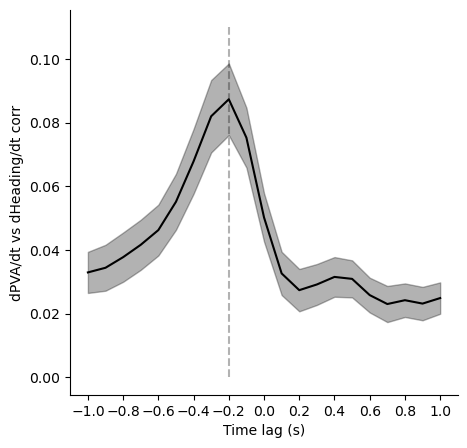

In [34]:
xcorr = epg_image_xcorr_loop(sess_df)


fig, ax = plt.subplots( figsize=[5,5])

##
mu, sem = xcorr.mean(axis=0), sp.stats.sem(xcorr, axis=0)
_ = ax.plot(common_times, mu, color='black')
_ = ax.fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)
_ = ax.plot([-.2,-.2], [-.0, .11], 'k--', alpha=.3)

ax.set_xticks(common_times[::2])

ax.set_ylabel('dPVA/dt vs dHeading/dt corr')
ax.set_xlabel('Time lag (s)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(figfolder / 'xcorr_all.pdf', bbox_inches='tight')

# EPG EL co-imaging

In [24]:
sess_df = pd.read_csv('/media/mplitt/SSD_storage/2P_scratch/EPG_EL_dual_imaging/sessions.csv')
sess_df = sess_df.loc[(sess_df['usable']==1)]



def epg_el_dual_image_xcorr_loop(df):
    basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch')
    xcorr_chan0_arr, xcorr_chan1_arr = [], []
    # for each session
    for _,row in df.iterrows():
        outdir = pathlib.PurePath( basedir / row['genotype_dir'] / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')
        
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        # calculate cross correlation
        xcorr_chan0, times = corr_w_lags(pp, chan=0)
        xcorr_chan1, _ = corr_w_lags(pp, chan=1)
        # resample to across fly timing using linear splines
        spline = interp1d(times, xcorr_chan0, kind='linear')
        xcorr_chan0_arr.append(spline(common_times))
        
        spline = interp1d(times, xcorr_chan1, kind='linear')
        xcorr_chan1_arr.append(spline(common_times))

    return np.array(xcorr_chan0_arr), np.array(xcorr_chan1_arr)

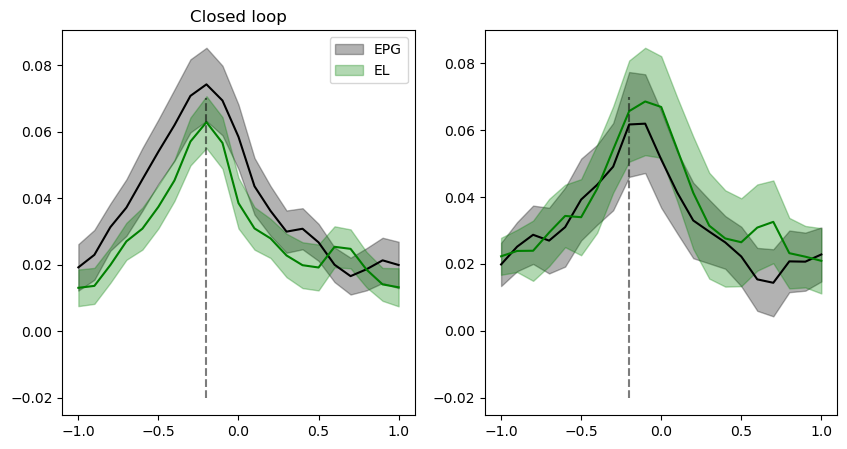

In [29]:
xcorr_cl = epg_el_dual_image_xcorr_loop(sess_df.loc[(sess_df['closed_loop']>0)])
xcorr_dark = epg_el_dual_image_xcorr_loop(sess_df.loc[(sess_df['closed_loop']==0)])


fig, ax = plt.subplots(1,2, figsize=[10,5])
mu, sem = xcorr_cl[0].mean(axis=0), sp.stats.sem(xcorr_cl[0],axis=0)
_ = ax[0].plot(common_times, mu, color='black')
_ = ax[0].fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3, label='EPG')
_ = ax[0].plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)

mu, sem = xcorr_cl[1].mean(axis=0), sp.stats.sem(xcorr_cl[1],axis=0)
_ = ax[0].plot(common_times, mu, color='green')
_ = ax[0].fill_between(common_times, mu-sem, mu+sem, color='green', alpha = .3, label='EL')
_ = ax[0].plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)
ax[0].set_title('Closed loop') 
ax[0].legend()

# 
mu, sem = xcorr_dark[0].mean(axis=0), sp.stats.sem(xcorr_dark[0],axis=0)
_ = ax[1].plot(common_times, mu, color='black')
_ = ax[1].fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3, label='EPG')
_ = ax[1].plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)

mu, sem = xcorr_dark[1].mean(axis=0), sp.stats.sem(xcorr_dark[1],axis=0)
_ = ax[1].plot(common_times, mu, color='green')
_ = ax[1].fill_between(common_times, mu-sem, mu+sem, color='green', alpha = .3, label='EL')
_ = ax[1].plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)


# GRAB OA

In [32]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R20A02_R56H10_split_GRABOA1')

sess_df = pd.read_csv(basedir / 'sessions.csv')
# print(sess_df.columns)
sess_df = sess_df.loc[(sess_df['usable']==1)]


In [33]:
def graboa_xcorr_loop(df):
    
    xcorr_arr = []
    # for each session
    for _,row in df.iterrows():
        outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')
        
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        # calculate cross correlation
        xcorr, times = corr_w_lags(pp)
        # resample to across fly timing using linear splines
        spline = interp1d(times, xcorr, kind='linear')

        xcorr_arr.append(spline(common_times))

    return np.array(xcorr_arr)

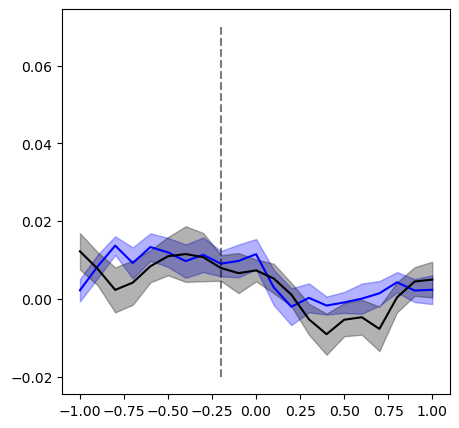

In [34]:
xcorr_cl = graboa_xcorr_loop(sess_df.loc[(sess_df['closed_loop']>0)])
xcorr_dark = graboa_xcorr_loop(sess_df.loc[(sess_df['closed_loop']==0)])

fig, ax = plt.subplots( figsize=[5,5])

##
mu, sem = xcorr_cl.mean(axis=0), sp.stats.sem(xcorr_cl, axis=0)
_ = ax.plot(common_times, mu, color='blue')
_ = ax.fill_between(common_times, mu-sem, mu+sem, color='blue', alpha = .3)
_ = ax.plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)

mu, sem = xcorr_dark.mean(axis=0), sp.stats.sem(xcorr_dark, axis=0)
_ = ax.plot(common_times, mu, color='black')
_ = ax.fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)
_ = ax.plot([-.2,-.2], [-.02, .07], 'k--', alpha=.3)

# GRABDA shift to get maximal spearmann correlation 